
Available images:
1: Image019_ch00.tif
2: Image021_ch00.tif
3: Image022_ch00.tif

Select the image number to process or type 'exit' to quit: 1


C:\Users\Admin\anaconda3\lib\site-packages\skimage\_shared\utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


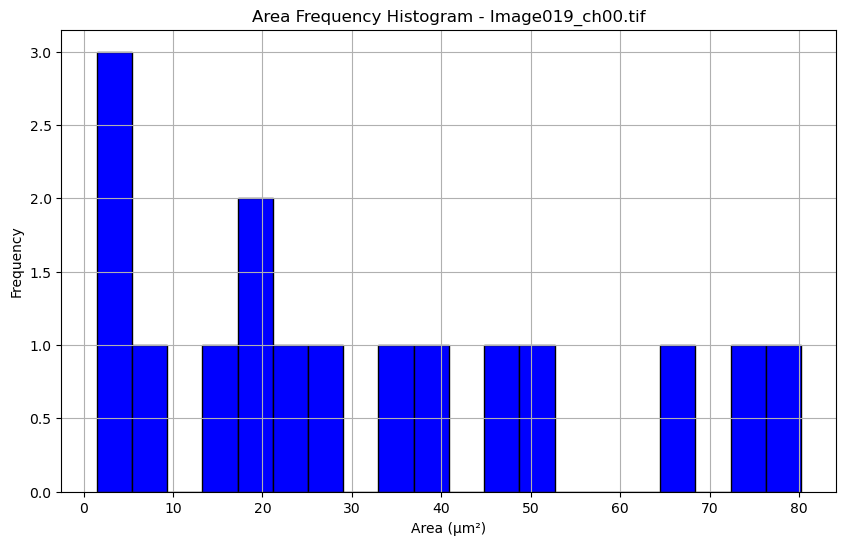

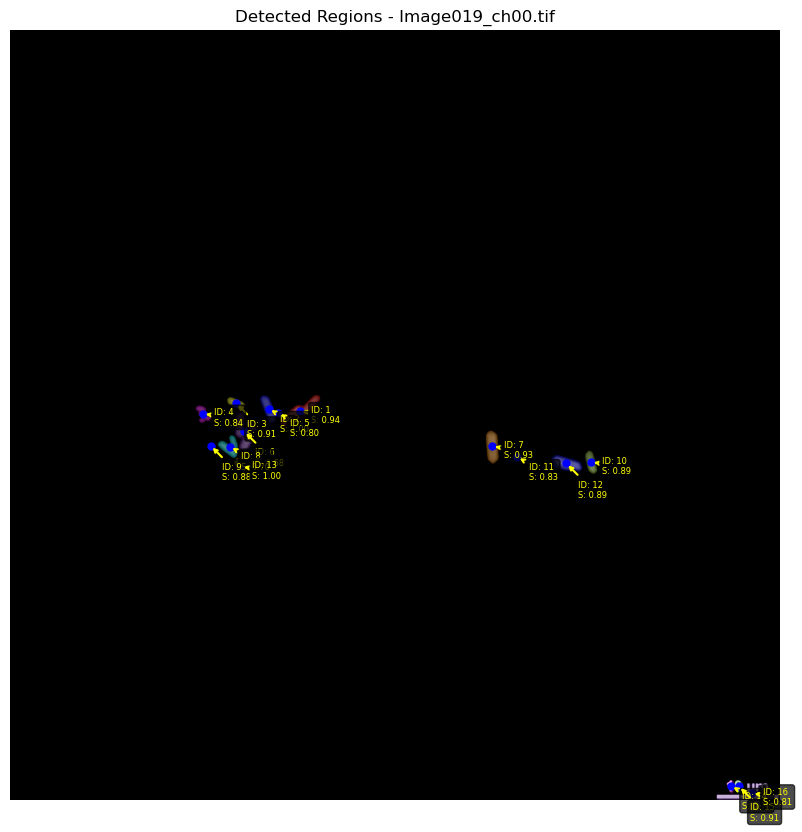


Available images:
1: Image019_ch00.tif
2: Image021_ch00.tif
3: Image022_ch00.tif

Select the image number to process or type 'exit' to quit: 2


C:\Users\Admin\anaconda3\lib\site-packages\skimage\_shared\utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


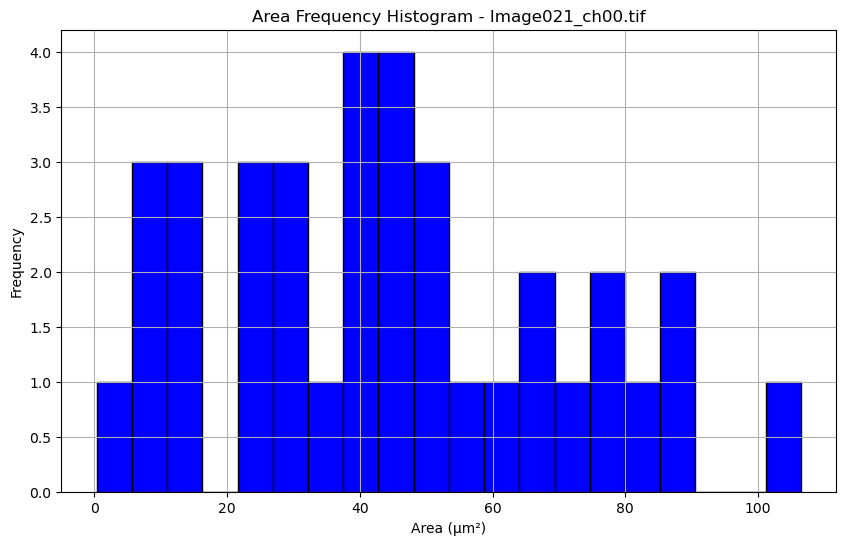

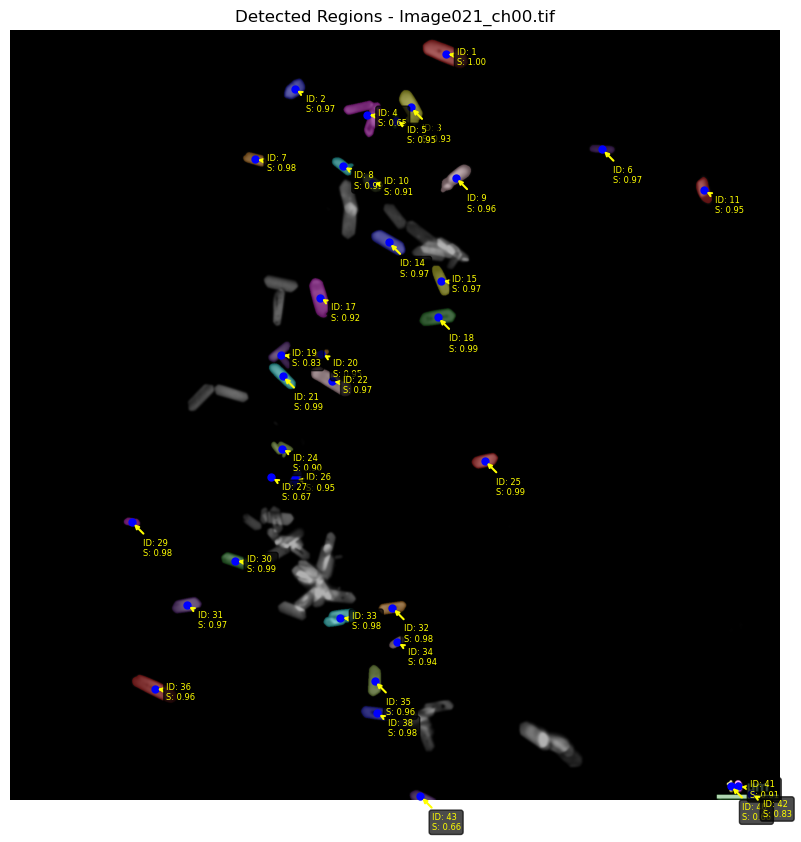


Available images:
1: Image019_ch00.tif
2: Image021_ch00.tif
3: Image022_ch00.tif

Select the image number to process or type 'exit' to quit: 3


C:\Users\Admin\anaconda3\lib\site-packages\skimage\_shared\utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


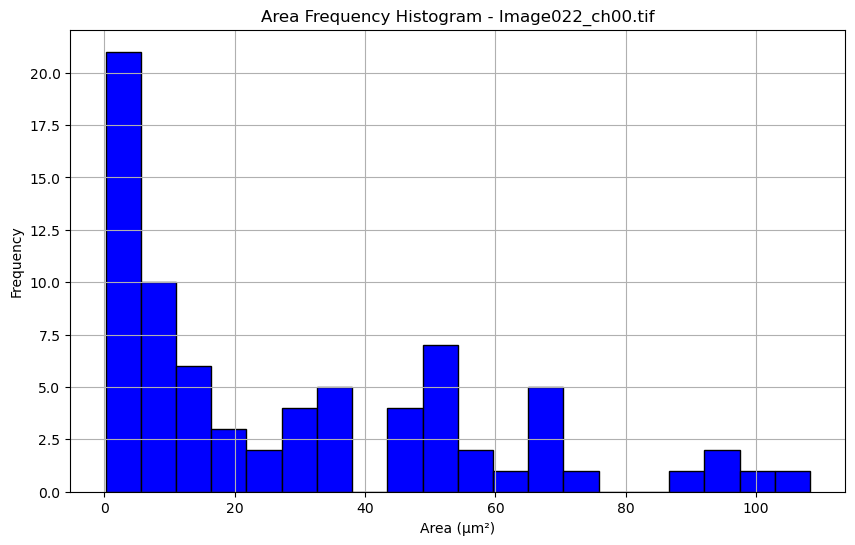

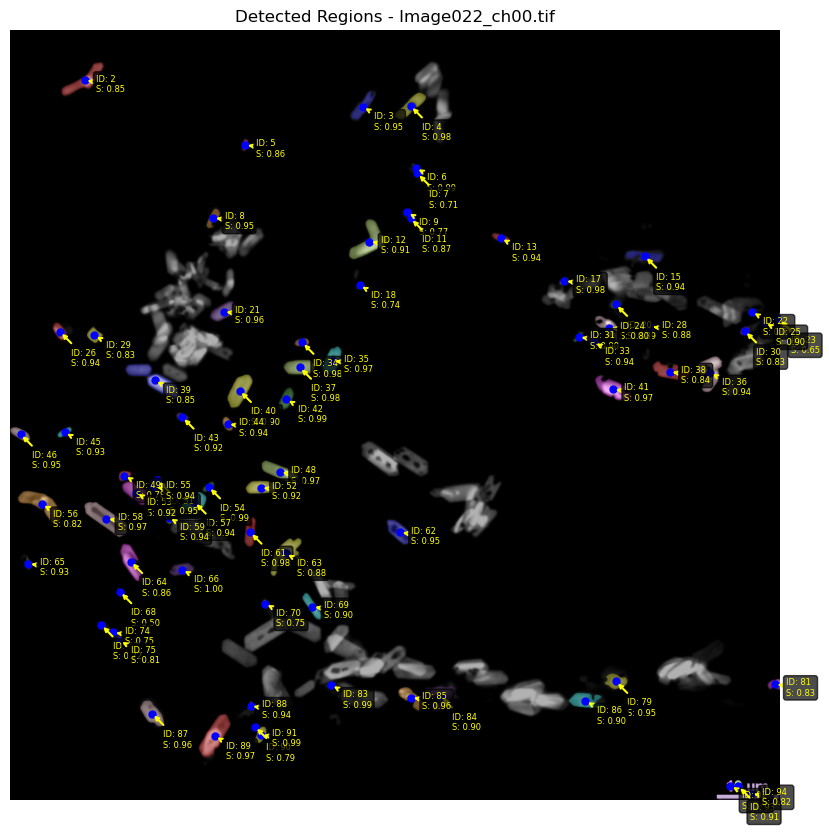


Available images:
1: Image019_ch00.tif
2: Image021_ch00.tif
3: Image022_ch00.tif

Select the image number to process or type 'exit' to quit: exit
Results saved to C:\Users\Admin\Downloads\research fish 2024\WT\data_fish_WT.xlsx.


In [1]:
### FUNCIONA!!!!!!!!!!!!!!!!!!!!!!!!1
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage.color import rgb2gray, label2rgb
from skimage import morphology, measure, exposure
from skimage.morphology import area_closing, opening, remove_small_objects
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
import math

# Function to remove large objects that do not resemble ellipses
def remover_objetos_grandes_no_elipticos(label_img, max_area=5500, min_aspect_ratio=0.1, min_extent=0.5,min_object_size=1000):
    cleaned_label_img = np.zeros_like(label_img)
    
    for region in regionprops(label_img):
        area = region.area
        major_axis = region.major_axis_length
        minor_axis = region.minor_axis_length

        # Calculate the ellipticity ratio
        if major_axis > 0:
            aspect_ratio = minor_axis / major_axis
        else:
            aspect_ratio = 0

        # Conditions for considering the region as elliptical
        if area <= max_area and aspect_ratio >= min_aspect_ratio:
            cleaned_label_img[label_img == region.label] = region.label

    return cleaned_label_img

# Pixel-to-micrometer scale
pixel_to_um = 1 / 7.0917

# Directory containing images
img_dir = 'C:\\Users\\Admin\\Downloads\\research fish 2024\\WT\\'
#img_dir = 'C:\\Users\\Admin\\Downloads\\research fish 2024\\'

output_group_excel = 'C:\\Users\\Admin\\Downloads\\research fish 2024\\WT\\data_fish_WT.xlsx'
#output_group_excel = 'C:\\Users\\Admin\\Downloads\\research fish 2024\\data_fish.xlsx'

# Get the list of image files
image_files = [f for f in os.listdir(img_dir) if f.endswith('.tif')]

if not image_files:
    print("No images found in the specified directory.")
else:
    # Initialize a global DataFrame to store results
    global_df = pd.DataFrame()

    while True:
        print("\nAvailable images:")
        for idx, img_name in enumerate(image_files):
            print(f"{idx + 1}: {img_name}")

        # Ask user to select an image or exit
        choice = input("\nSelect the image number to process or type 'exit' to quit: ").strip()

        if choice.lower() == 'exit':
            break

        try:
            img_index = int(choice) - 1
            if img_index < 0 or img_index >= len(image_files):
                print("Invalid number. Please try again.")
                continue

            # Load the selected image
            img_file = image_files[img_index]
            img_path = os.path.join(img_dir, img_file)
            loaded_img = cv2.imread(img_path)  # Load image in BGR format by default
            
            if loaded_img is None:
                raise ValueError(f"Could not load image at {img_path}. Ensure it is a valid image file.")
            
            # Convert to grayscale and enhance contrast with CLAHE
            gray_img = rgb2gray(loaded_img)
            
            gray_img = exposure.equalize_adapthist(gray_img)

            # Apply bilateral filter to reduce noise
            gray_img = cv2.bilateralFilter((gray_img * 255).astype(np.uint8), 9, 75, 75)

            # Calculate dynamic threshold
            mean_intensity = np.mean(gray_img)
            std_intensity = np.std(gray_img)
            #WT
            #dynamic_threshold = mean_intensity + 1 * std_intensity  # Adjust multiplier (1.5) if needed
            #NOT WT
            #dynamic_threshold = mean_intensity
            dynamic_threshold = mean_intensity + 1 * std_intensity  # Adjust multiplier (1.5) if needed
            #dynamic_threshold = mean_intensity 

            # Apply dynamic threshold
            binarized = (gray_img > dynamic_threshold).astype(np.uint16)

            """
            gray_img = exposure.equalize_adapthist(gray_img)
            
            # Apply bilateral filter to reduce noise
            gray_img = cv2.bilateralFilter((gray_img * 255).astype(np.uint8), 9, 75, 75)

            # Apply thresholding
            #_, binarized = cv2.threshold(gray_img, 255, 0, cv2.THRESH_TRUNC)
            #binarized = (binarized > 60).astype(np.uint16)
            
            binarized = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,21, 2)
            """
            # Morphological operations
            binarized = morphology.remove_small_holes(binarized, area_threshold=500)
            binarized = morphology.dilation(binarized, morphology.disk(1))
            binarized = area_closing(binarized, area_threshold=500)
            binarized = opening(binarized)
            
            # Label regions
            labels = label(binarized)
            
            # Remove large, non-elliptical objects
            labels = remover_objetos_grandes_no_elipticos(labels, max_area=5500, min_aspect_ratio=0.1, min_extent=0.5,min_object_size=1000)

            # Measure region properties
            red_channel = loaded_img[:, :, 2]  # Use the red channel
            props = measure.regionprops(labels, red_channel)

            props_data = []
            for prop in props:
                if prop.area > 0:  # Ensure the area is non-zero
                    area_um2 = prop.area * (pixel_to_um ** 2)
                    minor_axis_length_um = prop.minor_axis_length * pixel_to_um
                    major_axis_length_um = prop.major_axis_length * pixel_to_um
                    perimeter_um = prop.perimeter * pixel_to_um
                    equivalent_radius_um = math.sqrt(area_um2 / np.pi)
                    """
                    # Calculate coefficient "S"
                    if major_axis_length_um > 0:
                        coefficient_s = minor_axis_length_um / major_axis_length_um
                    else:
                        coefficient_s = np.nan  # Avoid division by zero
                    """
                    # Calculate centroid distances to left and right borders
                    min_row, min_col, max_row, max_col = prop.bbox
                    centroid_y, centroid_x = prop.centroid
                    distance_left = (centroid_x - min_col) * pixel_to_um
                    distance_right = (max_col - centroid_x) * pixel_to_um
                    distance_down = (centroid_y - min_row) * pixel_to_um
                    distance_up = (max_row - centroid_y) * pixel_to_um

                    # Compute coefficient_S
                    if max(distance_left, distance_right) > 0:
                        coefficient_S1 = min(distance_left, distance_right) / max(distance_left, distance_right)
                    else:
                        coefficient_S1 = np.nan  # Avoid division by zero
                        
                    if max(distance_down, distance_up) > 0:
                        coefficient_S2 = min(distance_down, distance_up) / max(distance_down, distance_up)
                    else:
                        coefficient_S2 = np.nan  # Avoid division by zero

                    # Calculate angles at the vertices of the region
                    bbox = prop.bbox  # Bounding box: (min_row, min_col, max_row, max_col)
                    min_row, min_col, max_row, max_col = bbox
                    vertices = [
                        (min_row, min_col),
                        (min_row, max_col),
                        (max_row, min_col),
                        (max_row, max_col)
                    ]
        
                    # Compute angles
                    angles = []
                    for i, v1 in enumerate(vertices):
                        v2 = vertices[(i + 1) % len(vertices)]  # Next vertex
                        delta_y = v2[0] - v1[0]
                        delta_x = v2[1] - v1[1]
                        angle = math.degrees(math.atan2(delta_y, delta_x))
                        angles.append(angle)


                    # Add properties to the list
                    props_data.append({
                        'image': img_file,
                        'label_id': prop.label,
                        'minor_axis_length_um': minor_axis_length_um,
                        'major_axis_length_um': major_axis_length_um,
                        'area_um2': area_um2,
                        'perimeter_um': perimeter_um,
                        'equivalent_radius_um': equivalent_radius_um,
                        's1': distance_left,
                        's2': distance_right,
                        'S_HORIZONTAL': coefficient_S1,
                        's3': distance_left,
                        's4': distance_right,
                        'S_VERTICAL': coefficient_S2,
                        'angles_at_vertices': angles  # Save the list of angles
                    })

            df = pd.DataFrame(props_data)
            df_filtered = df[df['area_um2'] > 0]
            global_df = pd.concat([global_df, df_filtered], ignore_index=True)

            # Visualize labeled image with overlays
            labeled_img = label2rgb(labels, image=gray_img, bg_label=0, alpha=0.3)

            # Display histogram of areas
            plt.figure(figsize=(10, 6))
            plt.hist(df_filtered['area_um2'], bins=20, color='blue', edgecolor='black')
            plt.title(f'Area Frequency Histogram - {img_file}')
            plt.xlabel('Area (µm²)')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()

            # Plot regions with labels
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.imshow(labeled_img)

            for index, prop in enumerate(props):
                centroid_y, centroid_x = prop.centroid
                #label_text = f'ID: {props_data[index]["label_id"]:.2f}'
                #label_text = f'S: {props_data[index]["coefficient_S"]:.2f}'
                #label_text = f'Area: {props_data[index]["area_um2"]:.2f} µm²'
                label_text = (
                    f'ID: {props_data[index]["label_id"]}\n'
                    f'S: {props_data[index]["coefficient_S"]:.2f}'
                )

                # Draw a marker on the centroid
                ax.plot(centroid_x, centroid_y, 'o', color="blue", markersize=5)

                # Annotate with the label
                label_offset_x = 30
                label_offset_y = 30 * (index % 3 + 1)  # Vary vertical offset for readability
                
                ax.annotate(
                    label_text,
                    xy=(centroid_x, centroid_y),
                    xytext=(centroid_x + label_offset_x, centroid_y + label_offset_y),
                    color="yellow",
                    fontsize=6,
                    bbox=dict(facecolor="black", alpha=0.7, boxstyle="round,pad=0.3"),
                    arrowprops=dict(arrowstyle="->", color="yellow", lw=1.5)
                )
                

            ax.set_title(f'Detected Regions - {img_file}')
            plt.axis("off")
            plt.show()

        except Exception as e:
            print(f"An error occurred: {e}")
    # Save results to Excel
    with pd.ExcelWriter(output_group_excel) as writer:
        global_df.to_excel(writer, sheet_name='All Results', index=False)
    print(f"Results saved to {output_group_excel}.")